In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation")
!ls

 data_balanced_1000.obj     elliptic_txs_edgelist.csv   GRL_2.ipynb
 data_balanced_500.obj	    elliptic_txs_features.csv  'GRL_FINAL (4).ipynb'
 data.obj		    GAT_1		        GRL.ipynb
 elliptic_txs_classes.csv   GAT_2		        NoteBooks


In [ ]:
#PYTORCH INSTALL
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [4]:
import pickle   
import torch
from torch_geometric.data import Data

fileObj = open('data.obj', 'rb')
data = pickle.load(fileObj)
fileObj.close()
print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], n_id=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])


In [5]:
#USE GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
#EDW NA DW ALLES PERIPTWSEIS GIA BATCHES!!!
#Epishs na dw th lista me tous geitones
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(data,num_neighbors=[-1, -1], shuffle=True,batch_size=203769)

counter = 0
for batch in train_loader:

    print(len(batch.n_id))
    print(len(batch.y))
    print(type(batch))
    print(batch.test_mask)

203769
203769
<class 'torch_geometric.data.data.Data'>
tensor([False, False, False,  ..., False, False, False])


In [7]:
#SCRIPT 16
#METRICS
!pip install torchmetrics
from torchmetrics.classification import AUROC
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryConfusionMatrix
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import BinaryF1Score

confmat = BinaryConfusionMatrix()
recall = MulticlassRecall(num_classes=2, average=None)
precision = MulticlassPrecision(num_classes=2, average=None)
aucroc = MulticlassAUROC(task="multiclass", num_classes=2)
metric = BinaryF1Score(average=None)

def conf_matrix(pred_y, y):
  #confmat = BinaryConfusionMatrix().to(device)

  return confmat(pred_y, y)

def brecall(pred_y, y):
  #recall = BinaryRecall().to(device)
  #recall = MulticlassRecall(num_classes=2, average=None).to(device)

  return recall(pred_y, y)

def bprecision(pred_y, y):
  #precision = MulticlassPrecision(num_classes=2, average=None).to(device)

  return precision(pred_y, y)

def auc_roc(pred_y, y):
  #aucroc = AUROC(task="binary").to(device)
  #print('AUC ROC',pred_y[:10])
  #print('AUC ROC',y.shape)
  #aucroc = MulticlassAUROC(task="multiclass", num_classes=2).to(device)

  return aucroc(pred_y, y)

def f1score(pred_y, y):
  #metric = BinaryF1Score(average=None).to(device)

  return metric(pred_y, y)


def accuracy(pred_y, y):
    
    return ((pred_y == y).sum() / len(y)).item() 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.8 MB/s 


In [8]:
def train(model,epochs,yes_no):

    weigths = [2.5, 0.625]

    if yes_no == True:

      wei = torch.FloatTensor(weigths).to(device)
      print('WEIGTHS = ',wei)
      criterion = torch.nn.CrossEntropyLoss(weight=wei)
    else:
      criterion = torch.nn.CrossEntropyLoss()

    #criterion = torch.nn.CrossEntropyLoss()
    #criterion2 = torch.nn.NLLLoss()
    optimizer = model.optimizer

    train_loss_total = []
    val_loss_total = []
    best_model = model
    best_val_loss = 1000.0

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      total_val_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0
      auc_roc_train = 0
      auc_roc_val = 0 
      pre_train = 0 
      pre_val = 0
      recall_train = 0
      recall_val = 0
      f1_train = 0
      f1_val = 0
      nll_loss_train = 0
      nll_loss_val = 0
 
      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        
        logit, out = model(batch.x, batch.edge_index)
        loss = criterion(logit[batch.train_mask], batch.y[batch.train_mask])
        total_loss += float(loss)

        #nll_loss_train = criterion2(out[batch.train_mask], batch.y[batch.train_mask])
        #nll_loss_val = criterion2(out[batch.val_mask], batch.y[batch.val_mask])
        

        acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        auc_roc_train += auc_roc(out[batch.train_mask], batch.y[batch.train_mask])
        pre_train += bprecision(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        recall_train += brecall(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        f1_train += f1score(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
        conf_matrix_train = conf_matrix(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])

        print(conf_matrix_train)

        loss.backward()
        optimizer.step()

        del auc_roc_train
        del pre_train
        del recall_train
        del f1_train
        del conf_matrix_train

        with torch.no_grad():
        # Validation
         val_loss = criterion(logit[batch.val_mask], batch.y[batch.val_mask])
         total_val_loss += float(val_loss)

         val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
         auc_roc_val += auc_roc(out[batch.val_mask], batch.y[batch.val_mask])
         pre_val += bprecision(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
         recall_val += brecall(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])
         f1_val += f1score(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
         conf_matrix_val = conf_matrix(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

         del conf_matrix_val
         del f1_val
         del recall_val
         del pre_val
         del auc_roc_val
        

         #print(conf_matrix_val)
         #print('TRAIN LOSS', loss)
         print('VALIDATION LOSS', val_loss)

         #print("Train accuracy = ", acc/len(train_loader), "Val accuracy = ", val_acc/len(train_loader))
         #print("AUC ROC SCORE TRAIN = ",auc_roc_train/len(train_loader),"AUC ROC SCORE VAL = ", auc_roc_val/len(train_loader))
         #print("precision SCORE TRAIN = ",pre_train/len(train_loader),"precision SCORE VAL = ", pre_val/len(train_loader))
         #print("RECALL SCORE TRAIN = ",recall_train/len(train_loader),"RECALL SCORE VAL = ", recall_val/len(train_loader))
         #print("F1 SCORE TRAIN = ",f1_train/len(train_loader),"F1 SCORE VAL = ", f1_val/len(train_loader))

         if(val_loss < best_val_loss):
          best_val_loss = val_loss
          best_model = model
          print("NEW BEST at epoch ", epoch)
         train_loss_total.append(total_loss)
         val_loss_total.append(val_loss)
      
    return best_model, train_loss_total, val_loss_total

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    
    with torch.no_grad():
     model.eval()
     _, out = model(data.x, data.edge_index)
     out = out.cpu().detach()
     acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
     auc_roc_acc = auc_roc(out[data.test_mask], data.y[data.test_mask])
     precision_score = bprecision(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
     recall_score = brecall(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
     f1_test = f1score(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
     conf_mat = conf_matrix(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])

     del auc_roc_acc, precision_score,recall_score, f1_test,conf_mat 


    return acc, 0, 0, 0,0, 0

def test2(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    results = []
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    auc_roc_acc = auc_roc(out[data.test_mask], data.y[data.test_mask])
    precision_score = bprecision(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    recall_score = brecall(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    f1_test = f1score(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    conf_mat = conf_matrix(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])

    
    results.append(auc_roc_acc[0].detach())
    


    return results



In [ ]:
from sklearn.utils import class_weight
import numpy as np
list_ones = [1]*2000
list_zero = [0]*500
list1 = list_ones + list_zero
print(len(list1))
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(list1),y=list1)
print(class_weights)

2500
[2.5   0.625]


In [9]:
#TRAIN FUNC 2 WITH WEIGTHS

def train2(model, epochs,yes_no):
    weigths = [2.5, 0.625]

    if yes_no == True:

      wei = torch.FloatTensor(weigths).to(device)
      print('WEIGTHS = ',wei)
      criterion = torch.nn.CrossEntropyLoss(weight=wei)
    else:
      criterion = torch.nn.CrossEntropyLoss()

    optimizer = model.optimizer
    
    model.train()

    train_loss_total = []
    val_loss_total = []
    best_model = model
    best_val_loss = 1000.0
    
    for epoch in range(epochs+1):
      total_loss = 0
      total_val_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0
      auc_roc_train = 0
      auc_roc_val = 0 
      pre_train = 0 
      pre_val = 0
      recall_train = 0
      recall_val = 0
      f1_train = 0
      f1_val = 0
 
      # Train on batches
      
      optimizer.zero_grad()
        
      logit, out = model(data.x, data.edge_index)
      loss = criterion(logit[data.train_mask], data.y[data.train_mask])
      #total_loss += loss

      acc += accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      auc_roc_train += auc_roc(out[data.train_mask], data.y[data.train_mask])
      pre_train += bprecision(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      recall_train += brecall(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      f1_train += f1score(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      conf_matrix_train = conf_matrix(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      print(conf_matrix_train)
      loss.backward()
      optimizer.step()

        # Validation
      val_loss = criterion(logit[data.val_mask], data.y[data.val_mask])
      #total_val_loss += val_loss
      print('TRAIN LOSS', loss)
      print('VALIDATION LOSS', val_loss)

      val_acc += accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      auc_roc_val += auc_roc(out[data.val_mask], data.y[data.val_mask])
      pre_val += bprecision(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      recall_val += brecall(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      f1_val += f1score(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      conf_matrix_val = conf_matrix(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
      print(conf_matrix_val)

      print("Train accuracy = ", acc, "Val accuracy = ", val_acc)
      print("AUC ROC SCORE TRAIN = ",auc_roc_train,"AUC ROC SCORE VAL = ", auc_roc_val)
      print("precision SCORE TRAIN = ",pre_train,"precision SCORE VAL = ", pre_val)
      print("RECALL SCORE TRAIN = ",recall_train,"RECALL SCORE VAL = ", recall_val)
      print("F1 SCORE TRAIN = ",f1_train,"F1 SCORE VAL = ", f1_val)

      if(val_loss < best_val_loss):
        best_val_loss = val_loss
        best_model = model
        print("NEW BEST at epoch ", epoch)
      train_loss_total.append(loss.detach())
      val_loss_total.append(val_loss.detach())  

    return best_model, train_loss_total, val_loss_total  

In [10]:
import numpy as np
import pandas as pd
import os
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric
from torch.nn import Parameter
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import urllib.request
import tarfile
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
#HYPER PARAMETERS DICTIONARYS
#FOR GAT
import itertools

layers_GAT = [2,3]
embe_GAT = [64,128]
loader_GAT = [0,1]
heads_GAT = [4,8]
GAT_HPs = []
GAT_HPs.append(layers_GAT)
GAT_HPs.append(embe_GAT)
GAT_HPs.append(loader_GAT)
GAT_HPs.append(heads_GAT)


class GATmodel(torch.nn.Module):
    def __init__(self,layers,emb_size,head_num):
        super(GATmodel, self).__init__()
        self.hid = emb_size
        self.in_head = head_num
        self.out_head = 1
        self.layers = layers

        
        if self.layers == 3:
          self.conv1 = GATConv(165, self.hid, heads=self.in_head, dropout=0.6)
          self.conv = GATConv(self.hid*self.in_head, self.hid, heads=self.in_head, dropout=0.6)
          self.conv2 = GATConv(self.hid*self.in_head, self.hid, heads=self.in_head, dropout=0.6)
          self.linear = torch.nn.Linear(self.hid*self.in_head,2)
          self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)
        else:
          self.conv1 = GATConv(165, self.hid, heads=self.in_head, dropout=0.6)
          self.conv2 = GATConv(self.hid*self.in_head, self.hid, heads=self.in_head, dropout=0.6)
          self.linear = torch.nn.Linear(self.hid*self.in_head,2)
          self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)  
          

    def forward(self,x, edge_index):
        
        # Dropout before the GAT layer is used to avoid overfitting

        if self.layers == 3:

          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv1(x, edge_index)
          x = F.elu(x)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv(x, edge_index)
          x = F.elu(x)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv2(x, edge_index)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.linear(x)
        else:
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv1(x, edge_index)
          x = F.elu(x)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.conv2(x, edge_index)
          x = F.dropout(x, p=0.6, training=self.training)
          x = self.linear(x)
            
        return x,F.softmax(x, dim=1)    


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self,num_layers, dim_h):
    super().__init__()

    self.num_layers = num_layers
    self.dim_hidden = dim_h
    
    if self.num_layers == 3:
      self.sage1 = SAGEConv(165, dim_h*2)
      self.sage2 = SAGEConv(dim_h*2, dim_h)
      self.sage3 = SAGEConv(dim_h, dim_h)
      self.linear = self.linear = torch.nn.Linear(dim_h,2)
      self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)
    else:
      self.sage1 = SAGEConv(165, dim_h*2)
      self.sage2 = SAGEConv(dim_h*2, dim_h)
      self.linear = self.linear = torch.nn.Linear(dim_h,2)
      self.optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=5e-4)
  def forward(self, x, edge_index):

    if self.num_layers == 3:
      h = self.sage1(x, edge_index)
      h = torch.relu(h)
      h = F.dropout(h, p=0.5, training=self.training)
      h = self.sage2(h, edge_index)
      h = torch.relu(h)
      h = F.dropout(h, p=0.2, training=self.training)
      h = self.sage3(h, edge_index)
      h = torch.relu(h)
      h = F.dropout(h, p=0.2, training=self.training)
      h = self.linear(h)

    else:
      h = self.sage1(x, edge_index)
      h = torch.relu(h)
      h = F.dropout(h, p=0.5, training=self.training)
      h = self.sage2(h, edge_index)
      h = torch.relu(h)
      h = F.dropout(h, p=0.2, training=self.training)
      h = self.linear(h)
       
    return h, F.log_softmax(h, dim=1)        

class AGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(165, 64)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(64, 2)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

    def forward(self, x, edge_index):
        x = F.dropout(x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
        x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        return x,F.log_softmax(x, dim=1) 

In [11]:
data = data.to(device)


In [ ]:
model1 = GraphSAGE(3,64).to(device)
print(model1)
best, trai_lo, val_lo = train(model1,train_loader,1,False)
one,t,three,four,five,six = test(best,data)


In [ ]:
gat_model2 = GATmodel(2,128,4).to(device)
best, trai_lo, val_lo = train(gat_model2,2,False)
one,two,three,four,five,six = test(best,data)
print(one,two,three,four,five,six)

tensor([[ 206,  294],
        [ 857, 1143]], device='cuda:0')
VALIDATION LOSS tensor(0.8294, device='cuda:0')
NEW BEST at epoch  0
tensor([[   0,  500],
        [   1, 1999]], device='cuda:0')
VALIDATION LOSS tensor(0.8579, device='cuda:0')
tensor([[  27,  473],
        [ 139, 1861]], device='cuda:0')
VALIDATION LOSS tensor(0.4789, device='cuda:0')
NEW BEST at epoch  2
0.08756536990404129 0 0 0 0 0


In [ ]:
gat_model3 = GATmodel(2,128,4).to(device)
best2, trai_lo, val_lo = train2(gat_model3,200,False)
one,two,three,four,five,six = test(best2,data)
print(one,two,three,four,five,six)

In [ ]:
print(trai_lo)
trai_lo = [i.detach().numpy() for i in trai_lo]
print(trai_lo)

[tensor(0.8362), tensor(1.5308)]
[array(0.83623964, dtype=float32), array(1.5307944, dtype=float32)]


In [ ]:
#print(t)
t = t.detach().numpy()
three = [i.detach().numpy() for i in three]
four = [i.detach().numpy() for i in four]
five = five.detach().numpy()
six = six.detach().numpy()
print(t,three,four,five,six)
#i = [i.detach().numpy() for i in five]
#print(type(i))

0.62621886 [array(0., dtype=float32), array(0.91243464, dtype=float32)] [array(0., dtype=float32), array(1., dtype=float32)] 0.9542126 [[    0  2545]
 [    0 26519]]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import pickle

os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/GAT")

for i in range(1):
  file2save_everything = open(str(i),'wb')
  gat_model2 = GATmodel(2,128,4).to(device)
  print(gat_model2)

  vaa2 = False

  best, trai_lo, val_lo = train(gat_model2,train_loader,2,vaa2)
  val = [i.cpu().detach().numpy() for i in trai_lo]
  val2 = [i.cpu().detach().numpy() for i in val_lo]

  one, two,three, four, five, six = test(best,data3)
  print(one,two,three,four,five,six)
  
  print('/////////////////////////////////////////////////////////////')
  torch.cuda.empty_cache()

In [ ]:
#trai_lo = trai_lo.cpu().detach().numpy()
print(trai_lo)
val = [i.cpu().detach().numpy() for i in trai_lo]
print(val)

[tensor(0.7602, device='cuda:0'), tensor(1.4457, device='cuda:0'), tensor(0.6446, device='cuda:0')]
[array(0.7602258, dtype=float32), array(1.4457095, dtype=float32), array(0.6445965, dtype=float32)]


In [ ]:
#TEST SET FOR GAT
#APO OTI FENETAI MA8AINEI NA DIALEGEI PANTA THN MAJORITY CLASS ISWS POLLA HEADS
acc_GAT, auc_roc_acc_GAT, precision_score_GAT, recall_score_GAT, f1_test, conf_mat_GAT = test(best,data3)
print(acc_GAT)
print(auc_roc_acc_GAT)
print(precision_score_GAT)
print(recall_score_GAT)
print(f1_test)
print(conf_mat_GAT)

0.8791287541389465
tensor(0.8489, device='cuda:0')
tensor([0.3533, 0.9465], device='cuda:0')
tensor([0.4582, 0.9195], device='cuda:0')
tensor(0.9328, device='cuda:0')
tensor([[ 1166,  1379],
        [ 2134, 24385]], device='cuda:0')


In [ ]:
gat_model7 = GATmodel(2,8,8).to(device)
data3 = data3.to(device)
print(gat_model7)
vaa = False

best, val, trainl = train2(gat_model7,data3,1,vaa)

In [ ]:
import pickle
import os

os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/GAT")


filename = '3-32-1-8.model'
file = open(filename, 'rb')

model = pickle.load(file)
train_lost = pickle.load(file)
val_lost = pickle.load(file)
accuracy = pickle.load(file)
roc = pickle.load(file)
precission = pickle.load(file)
recall = pickle.load(file)
f1s = pickle.load(file)
conf = pickle.load(file)

file.close()

In [ ]:
models_list = []
for xs in itertools.product(GAT_HPs[0], GAT_HPs[1], GAT_HPs[2], GAT_HPs[3]):
  models_list.append(xs)

print(models_list[0])


(2, 64, 0, 4)


In [ ]:
import os
import itertools
import matplotlib.pyplot as plt
import pickle
import gc

#data3 = data3.to(device)


os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation")

a = os.path.isdir('GAT')
if a == False:
  os.mkdir("GAT")

os.chdir("/content/drive/MyDrive/Diplomatic2/Implementation/GAT")

for xs in itertools.product(GAT_HPs[0], GAT_HPs[1], GAT_HPs[2], GAT_HPs[3]):
  num_layers = xs[0]
  embe_size = xs[1]
  loader = xs[2]
  num_heads = xs[3]
  loader = 0
  

  #print(num_layers,embe_size,loader,num_heads)
  architecture = str(num_layers) + '-' + str(embe_size) + '-' + str(loader) + '-' + str(num_heads) + '.model'
  #print(architecture)
  model = GATmodel(num_layers,embe_size,num_heads).to(device)
  
  if loader == 0:
    best_model, train_loss_total, val_loss_total = train(model,100,False)
  else:
    best_model, train_loss_total, val_loss_total = train2(model,100,False)  

  acc_GAT, auc_roc_acc_GAT, precision_score_GAT, recall_score_GAT, f1_test, conf_mat_GAT = test(best_model,data)

  #train_loss_total = [i.cpu().detach().numpy() for i in train_loss_total]
  #val_loss_total = [i.cpu().detach().numpy() for i in val_loss_total]

  #auc_roc_acc_GAT = auc_roc_acc_GAT.cpu().detach().numpy()
  #precision_score_GAT = [i.cpu().detach().numpy() for i in precision_score_GAT]
  #recall_score_GAT = [i.cpu().detach().numpy() for i in recall_score_GAT]
  #f1_test = f1_test.cpu().detach().numpy()
  #conf_mat_GAT = conf_mat_GAT.cpu().detach().numpy()
  del acc_GAT, auc_roc_acc_GAT, precision_score_GAT, recall_score_GAT, f1_test, conf_mat_GAT
  del best_model, train_loss_total, val_loss_total
  print('DELETED')

  #file2save_everything = open(architecture,'wb')
  #pickle.dump(best_model, file2save_everything)
  #pickle.dump(train_loss_total, file2save_everything)
  #pickle.dump(val_loss_total, file2save_everything)
  #pickle.dump(acc_GAT, file2save_everything)
  #pickle.dump(auc_roc_acc_GAT, file2save_everything)
  #pickle.dump(precision_score_GAT, file2save_everything)
  #pickle.dump(recall_score_GAT, file2save_everything)
  #pickle.dump(f1_test, file2save_everything)
  #pickle.dump(conf_mat_GAT, file2save_everything)

  #file2save_everything.close()
  gc.collect()
  torch.cuda.empty_cache()
   
  

tensor([[ 238,  262],
        [ 831, 1169]], device='cuda:0')
VALIDATION LOSS 0.8965597152709961
NEW BEST at epoch  0
tensor([[   5,  495],
        [  22, 1978]], device='cuda:0')
VALIDATION LOSS 0.5354516506195068
NEW BEST at epoch  1
tensor([[  18,  482],
        [  56, 1944]], device='cuda:0')
VALIDATION LOSS 0.4752202332019806
NEW BEST at epoch  2
tensor([[  97,  403],
        [ 308, 1692]], device='cuda:0')
VALIDATION LOSS 0.5464553236961365
tensor([[ 238,  262],
        [ 774, 1226]], device='cuda:0')
VALIDATION LOSS 0.7324999570846558
tensor([[ 130,  370],
        [ 424, 1576]], device='cuda:0')
VALIDATION LOSS 0.5827426910400391
tensor([[  30,  470],
        [ 107, 1893]], device='cuda:0')
VALIDATION LOSS 0.45543551445007324
NEW BEST at epoch  6
tensor([[  17,  483],
        [  34, 1966]], device='cuda:0')
VALIDATION LOSS 0.42519447207450867
NEW BEST at epoch  7
tensor([[   9,  491],
        [  21, 1979]], device='cuda:0')
VALIDATION LOSS 0.4109514057636261
NEW BEST at epoch  8

OutOfMemoryError: ignored

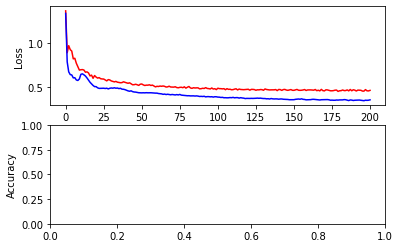

In [ ]:
import torch
arch = '1'
val2 = torch.stack(trai_lo).cpu().detach().numpy()
train2 = torch.stack(val_lo).cpu().detach().numpy()
fig, ax = plt.subplots(2)

ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')

ax[0].plot(val2, color='red') 
ax[0].plot(train2, color='blue') 

#ax[1].plot(history.history['accuracy'], color='red') 
#ax[1].plot(history.history['val_accuracy'], color='blue') 

filename2 = 'train_history'+str(arch)+'.png'
fig.savefig(filename2)
#plt.show()

In [ ]:
#TEST SET FOR GAT
#APO OTI FENETAI MA8AINEI NA DIALEGEI PANTA THN MAJORITY CLASS ISWS POLLA HEADS
acc_GAT, auc_roc_acc_GAT, precision_score_GAT, recall_score_GAT, conf_mat_GAT = test(best,data3)

print(acc_GAT)
print(auc_roc_acc_GAT)
print(precision_score_GAT)
print(recall_score_GAT)
print(conf_mat_GAT)

In [ ]:
import itertools

layers = [2,3]
embe = [64,128]
loader = [0,1]
heads = [4,8]
counter = 0
for xs in itertools.product(layers, embe, loader, heads):
  counter = counter +1
  print(xs)
print(counter)